![werwe](https://uploads-ssl.webflow.com/625391e03972c921373d60ba/6296d332b7e7cd998bf9035b_judge_logo_white.png)

&nbsp;



# Tutorial:  Towards a Sophisticated Research Methodology 

*Read time:  11 min.* 

&nbsp;

----

This tutorial demonstrates the ease-of-use and power of Judge Research.  If you complete it while referring back to our [wiki](https://judgeresearch.notion.site/The-Judge-Research-Wiki-37d2ae0159254928b483f01fec87b576) whenever a step's logic is not clear to you, you will be fully ready to use Judge Research.  

You can use Judge Research to (1) contribute to the decentralized systematic fund & be rewarded; (2) test competing operationalizations with extreme rigour; (3) compare findings from initial (validation set) findings and live findings as they come in; and (4) engineer features that represent something important about the market, and develop rich dashboards that communicate that information in real time.

----

![](https://uploads-ssl.webflow.com/625391e03972c921373d60ba/626b3edab9b30b7f49b3f554_23519116918_1a87106387_k.jpeg)






----

## Introduction

**The Workflow:**  You now have the data environment of a world-class hedge fund at your fingertips.  You can use it in this notebook to engage in feature engineering and display your preliminary findings in a single cohesive document; then submit your features to Judge Research and embed the live, interactive data tools from your dashboard into this document.    

**What it Accomplishes:**  With a few clicks, you turn this document into a live research tool linked up to an AI run on massively parallel processes & coded out by a team of PhDs.  It evaluates your features across millions of modeling contexts, ranks and compares them to what is in the market's larger data environment, and rigorously tests them for overfit.    

----


### The Tech Stack & the Decentralized Systematic Fund

This tutorial is meant for those who want to be rewarded for contributing to the decentralized systematic fund, and to use the fund as a new *kind* of research tool.  

We will soon be launching a SaaS version of the software.  It will allow you to take advantage of the above functionality without participating in the decentralized fund.  Your features & algorithms will be sent to a version of the AI that only looks at your fund's features and algorithms but still ranks & evaluates them for overfit in real time. 

Likewise, you can use the SaaS version to collaborate with other funds without revealing IP to one another.  We believe this type of collaboration is novel and has significant implications for the industry - allowing a small set of funds to match the capacities of the largest systematic funds.       

----

# Outline:  The Basic Steps for Submitting Your Features

There are **three preliminary steps:**  

1.  Authenticate & Setup the Workspace.
2.  Configure the parameters of the historical data you would like to call, and the parameters of the series you are studying - for instance, the BTC-USD volatility series at 45 minute intervals.
3.  Call, Organize & Clean the data.  

These three steps are broken out by their underlying functions in the longer tutorial.  Here, wrapper functions shorten about 30 lines of code to one.  

Step four is where you will spend 95% of your time:  Here you will **do your data exploration and feature engineering**.  There are then **three final steps:** 

5.  Submit your historical data.  This historical data submission will cover a time period from the beginning of a specified date - e.g. the 4 hr alpha test series begins on July  2019 - and continue up to the present moment.
6.  Schedule the cron job to submit live features.
7.  (Optional) Embed the data tools from your dashboard into the same notebook, writing up your findings to create live, interactive research tools and/or market signals. 

----



## 1.  Handle Your Authentications & Setup the Workspace
Paste your keys:

In [72]:
JR_API_KEY = "xxx" # Your Judge Research API was given to you upon sign-up.  You can find it under your profile.
CA_API_KEY = "xxx" # Sign up at Coinalytix.io - 90 days free and no payment information need be entered.

Import the Judge Research & Coinalytix packages, as well as the python tools want:

In [73]:
# Import classes that handle API connections and parameters
from historical_data import Coinalytix, HDParams
from judgeresearch import JudgeResearch, JRParams

# Import classes for data handling & visualization 
import json
import scipy 
import plotly.graph_objects as go
import pandas as pd
from datetime import date, datetime, timedelta
import pandas_ta as ta
import time
import math
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import requests # these two not in other imports
import json

import JudgeHelperFuncs as jh
from watchlist import colors

----

## 2. Configure Assets, Call, Organize & Clean the Data
Define the parameters for the historical data you want to call.  Typically, you want to line up the start date(s) of your historical data with the start date of the GA instance(s) to which you'll eventually submit features.  You can finds those dates in our [wiki](https://judgeresearch.notion.site/The-Judge-Research-Wiki-37d2ae0159254928b483f01fec87b576). The below calls data from `startDateString` to t-1. 

In [74]:
tc = jh.whichTickers(verbose = False, apiKey = CA_API_KEY, Which2 = 'ETH", Which='[0-9]+|PERP', WhichExch ='') # tc: this call
print(tc)

SyntaxError: invalid syntax (53671431.py, line 1)

In [65]:
XDict = jh.assetCallLoop(exchangeList = ['BINANCE'], assetList = tc[', startDateString = "2022-06-01 00:00:00", perSize = '4h', APIKey = CA_API_KEY, verbose = True)

calling BTC-USDT-SPOT
4h
calling ETH-USDT-SPOT
4h

% of columns that needed to be interpolated
StartDate    0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Volume       0.0
dtype: float64

dimensions of your DataFrame:
(291, 6)

...Call complete.


----

<img src = "https://uploads-ssl.webflow.com/625391e03972c921373d60ba/6296d332b7e7cd998bf9035b_judge_logo_white.png" width=400>

## 4.  The Main Section:  Your Feature Engineering Sandbox

It is good practice to write your preliminary findings down and frame explicitly the hypotheses you are investigating by sending your features into Judge Research.  Obviously, that is true with all research, but Judge Research is more than an AI:  It suggests an organization to your research that helps you confirm your intitial (validation set) findings with live data *at scale.*

That is easy for any professional researcher to do for a small set of findings, but to making research **truly cumulative over the long run** is one of the primary functions of Judge Research. 

In [66]:
btc = XDict['BTC-USDT-SPOT']
eth = XDict['ETH-USDT-SPOT']


y1 = (btc['Open'] - btc['Close']) / btc['Open']
y1 = y1

y1 = pd.concat(([btc['StartDate'], y1]), axis = 1)
y1.columns = ['StartDate', 'feature']
y1 = y1.applymap(str)

In [67]:
y1.head(5)

,StartDate,feature
StartDate,,
2022-06-01 00:00:00,1654041600.0,0.004565879796610718
2022-06-01 04:00:00,1654056000.0,0.004581484982910265
2022-06-01 08:00:00,1654070400.0,-0.004141996798210994
2022-06-01 12:00:00,1654084800.0,0.026795996102400566
2022-06-01 16:00:00,1654099200.0,0.01907776180284036


As a further example, here are the simple are some simple moving average functions.

In [69]:
def feature_gen(df):
    ''' calculate macd, awesome oscillator, and bbands '''
    
    # MACD
    df.ta.macd(fast=8, slow=21, signal=9, min_periods=None, append=True)
    
    # Awesome Oscillator 
    df.ta.ao(high=df["High"], low=df["Low"], window1=5, window2=34, fillna=True, append=True)
    df["AO_5_34"] = pd.to_numeric(df["AO_5_34"])
    
    # Bollinger Bands
    df.ta.bbands(close=df["Close"], append=True)
    
    # Calculate the feature by finding the difference of MACDs and AO, multiply by BBANDS
    df["feature"] = (df["AO_5_34"] - df["MACDs_8_21_9"]) * df["BBP_5_2.0"]
    df = df.fillna(0)
    return df
 

# Generate feature dataframe
fdf = feature_gen(eth)
fdf.tail(3)

,StartDate,Open,High,Low,Close,Volume,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,AO_5_34,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,feature
StartDate,,,,,,,,,,,,,,,,
2022-07-19 00:00:00,1.658189e+09,1581.03,1626.48,1512.48,1517.65,15660.0342,95.552788,13.815178,81.737610,235.690206,1433.660471,1513.244,1592.827529,10.518268,0.527682,81.237953
2022-07-19 04:00:00,1.658203e+09,1516.24,1542.68,1493.57,1513.71,10628.3027,91.432894,7.756227,83.676667,229.324676,1448.081674,1520.194,1592.306326,9.487253,0.455042,66.276014
2022-07-19 08:00:00,1.658218e+09,1510.59,1511.11,1510.58,1510.76,44.2981,86.285334,2.086933,84.198400,220.888618,1446.485411,1518.986,1591.486589,9.545919,0.443269,60.590594


### Research & Chart:

In [59]:
def ctitle(indicator_name, ticker="BTC-USD", length=100):
    return f"{ticker}: {indicator_name} from {recent_startdate} to {recent_enddate} ({length})"


def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

recent_startdate = fdf.tail(recent_bars(fdf)).index[0]
recent_enddate = fdf.tail(recent_bars(fdf)).index[-1]

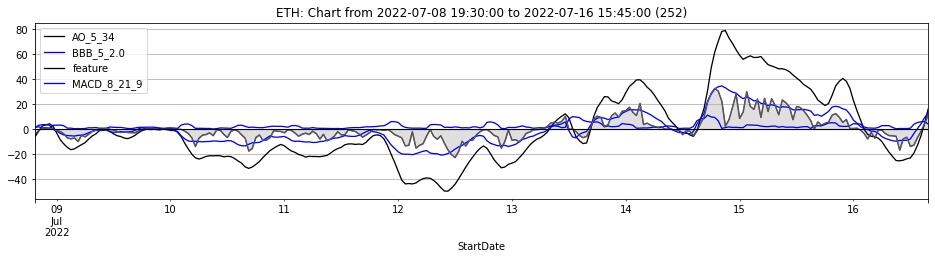

In [60]:
ind_size = (16, 3.25)
fdf[[fdf.columns[9], fdf.columns[13], fdf.columns[15], fdf.columns[6]]].tail(recent_bars(fdf)).plot(figsize=(16, 2), color=colors("BkBl"), linewidth=1.3)
fdf[fdf.columns[15]].tail(recent_bars(fdf)).plot.area(figsize=ind_size, stacked=False, color=["silver"], linewidth=1, title=ctitle("Chart", ticker='ETH', length=recent_bars(fdf)), grid=True).axhline(y=0, color="black", lw=1.1)

### Analysis here

Record your findings so they are clear to you and others in the **far off** in the future.  



In [61]:
%%html 
<script type='text/javascript' src='https://prod-useast-a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1000px; height: 850px;'><object class='tableauViz' width='1000' height='850' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;judgeresearchanalytics' /><param name='name' value='publicDemo1_LinePlot&#47;Dashboard3' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='display_count' value='n' /><param name='origin' value='viz_share_link' /><param name='showAppBanner' value='false' /></object></div>


----


<img src = "https://uploads-ssl.webflow.com/625391e03972c921373d60ba/6296d332b7e7cd998bf9035b_judge_logo_white.png" width=400>

## 7.  Reference your live findings

In steps 5 & 6, we submit our historicla data and our live data.  We put that at the end of the document, so we can make a cohesive research document here.  By embedding the data tools you find at Judge Research here, you hook this document up to our AI, making it a live, interactive tool.

----

### 7a.  The Overall Relationship With the Larger Data Environment - In Real Time

First, we explore our data with tools that show the relationship as it evolves in real time:

In [49]:

%%html
<script type='text/javascript' src='https://prod-useast-a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1852px; height: 974px;'><object class='tableauViz' width='1852' height='974' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;judgeresearchanalytics' /><param name='name' value='publicDemo1_LinePlot&#47;publicDemo1_InitialLineplot_1&#47;d2a274e3-3a03-46f0-ab7a-4a0dafafa7c5&#47;b45cc7e7-4c99-417d-b58c-69b69621e2d6' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='display_count' value='n' /><param name='origin' value='viz_share_link' /><param name='showAppBanner' value='false' /></object></div>


----

## 7b. And As Time Series:  

In [50]:
%%html
<script type='text/javascript' src='https://prod-useast-a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1000px; height: 850px;'><object class='tableauViz' width='1000' height='850' style='display:none;'><param name='host_url' value='https%3A%2F%2Fprod-useast-a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;judgeresearchanalytics' /><param name='name' value='publicDemo1_LinePlot&#47;Dashboard5' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='display_count' value='n' /><param name='origin' value='viz_share_link' /><param name='showAppBanner' value='false' /></object></div>



----

## 7c.  Digging Deeper into the Validation - Live Data juxtaposition:


In [51]:

%%html
<div class='tableauPlaceholder' id='viz1654618929623' style='position: relative'><noscript><a href='https:&#47;&#47;www.judgeresearch.co&#47;'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ST&#47;STHS7Q85B&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;STHS7Q85B' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ST&#47;STHS7Q85B&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='tabs' value='no' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1654618929623');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>




----

### 7d.  And the Broader Class of Models across Generations of the SBGA:

In [21]:
%%html
<div src = http://ec2-18-223-235-219.us-east-2.compute.amazonaws.com:3838/ShinyPractice/LinePlot/54ckzfe5tj/>

----





## Steps 5 and 6:  Submitting Your Historial & Live Series to Judge Research

Prepare the Connection to Judge Research:

In [10]:
JR = JudgeResearch()
JR.with_api_key(JR_API_KEY)

Format the Historical Features:  Below we specify which instance(s) of the AI are going to receive our feature(s).  Each instance is trained on a different dependent variable.   We communicate this to Judge Research by formatting our feature(s) as their JSON.  See the [API documentation in our wiki](https://judgeresearch.notion.site/Use-The-API-5143af17c10f407d91a8860a7c91936e) for information about each argument. 

For example, here we specify this submission is for BTC-USD at the 45 minute interval.   

In [13]:
ft_params = JRParams()
ft_params.mbs= "240" #                                mbs:  'minute bloc size' - the size of the discrete time bloc.  In the alpha test, options are 45 & 240.  
ft_params.feature_name = "BTCt" #            feature_name:  name it to represent the substance of the feature or generically so no one but you knows what it is; e.g. 'x1'
ft_params.ipp = "last" #                             ipp:  interpolation procedure - fill-in value if you miss a submission.  'last' or 'zero'

In [14]:
features = JR.craft_features(ft_params, y1)
payload = JR.format_payload(features)
submit = JR.submit_feature(payload)
print(submit)

<Response [200]>


----

## Live Feature Calculation and Submission

The below functions make submitting live features easy.  Paste it in a .py script that gets called in a cron job.      

Each data point is submitted three times.

When invoked, a first "safety" guess is calculated and submitted to ensure it is recorded well before the feature submission deadline.

The second and third submissions are send on user-configurable intervals calculated by percentage of time remaining before the close of the window.  For example, if the script is run 10 minutes before the close of a window with "firstdelay" set to 0.50 and the seconddelay set to "0.90" the execution would happen as follows:

- T-00:10 Initial Submission
- T-00:05 Second Submission
- T-00:09 Last Submission
- T-00:00 Feature Submission Deadline is Over

In [15]:
def fcs(asset, params):
    """ fetch, calculate, and submit once """
    hddf = HD.fetch_hd(asset)
    fdf = feature_gen(hddf)
    features = JR.craft_features(params, fdf)
    payload = JR.format_payload(features)
    submit = JR.submit_feature(payload)
    return submit
    
def live_fcs(asset, params, firstdelay, seconddelay):
        """
        calculate and submit feature data 3 times, throttled by percentage
        of time remaining until end of widow
        
        first submission = immediate
        second submission = % of remaining time in window ex. .30 = 3 minutes of 10 remaining
        last submission = % of remaining time in window ex, .90 = 9 of 10 remaining
        """
        
        # determine current time
        now = datetime.now()
        print("Current time: " + now.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # determine the upcoming deadline (end of window)
        # FIXME: don't assume windows are anchored to 00:00
        genesis_time = datetime.utcnow().today().replace(microsecond=0, second=0, minute=0, hour=0)
        
        # set deadline anchor time
        deadline = genesis_time
        print("Genesis: " + genesis_time.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # create timedelta object based on MBS parameter
        window = timedelta(minutes=int(params.mbs))
        
        # iterate through block times until current time is passed, set deadline
        while now > deadline:
            deadline = deadline + window
            
        print("Next Block End: " + deadline.strftime("%Y-%m-%dT%H:%M:%SZ"))
        
        # calculate time remaining until window close
        remaining = deadline - now
        
        # caculate delays (seconds)
        delay1 = int(remaining.total_seconds() * firstdelay)
        delay2 = int(remaining.total_seconds() * seconddelay) - delay1
        
        # submit immediately
        s1 = fcs(asset, ft_params)
        print("First submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))
        print(s1)
        
        # sleep, recalculate, and send agin
        time.sleep(delay1)
        s2 = fcs(asset, ft_params)
        print("Second submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))
        print(s2)
        
        # sleep, recalculate, and send final
        time.sleep(delay2)
        s3 = fcs(asset, ft_params)
        print("Final submission at " + datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))        
        print(s3)

In [16]:
live_fcs(asset, ft_params, .50, .90)

NameError: name 'asset' is not defined

In [79]:
from IPython.display import IFrame
IFrame('http://ec2-18-223-235-219.us-east-2.compute.amazonaws.com:3838/ShinyPractice/dev/', width=1200, height=350)